# Práctica Python
## Alumnos: _Tania Batista, Fernando de la Fuente, Lourdes Ruiz_
## Tema: Análisis del S&P 500
### Profesor: _Miguel Angel Sicilia_

Hemos elegido para la práctica una tabla de datos que contiene las cotizaciones de 503 valores que componen el índice de bolsa americana S&P 500 de 5 años, desde el 13 de Agosto de 2012 hasta el 11 de Agosto de 2017.
Los datos están extraídos de Kaggle, en el siguiente enlace:

[Kaggle S&P 500](https://www.kaggle.com/camnugent/sandp500/)

(Deberá de descargarse desde la pestaña __'Data'__ de Kaggle el fichero __'all_stocks_5yr.csv'__, y situarlo en el directorio desde donde hayamos abierto este notebook.)

A partir de la información de este fichero, sin tener los datos del índice, sino los de los valores que lo componen, haremos algunos estudios, así como la composición de un índice sintético.
Deicidimos componer un sintético debido a que:
* El índice real varía diariamente el peso de cada uno de los valores que lo componen, y el acceso a esta información que es necesaria para componer el índice real es de pago. 
* Periodicamente se reune un comité que decide qué valores entran y salen del índice, y a lo largo de los 5 años de los que tenemos datos ha habido varios valores que han entrado y otros que han salido. Nuestra base de datos contiene información de los 503 valores que componían el índice en fecha 14 de Agosto de 2017, y sobre esta información es sobre la que trabajaremos.

Por tanto, debido a estas limitaciones no es posible recomponer el índice real y comprobar los datos obtenidos con los de cualquier otra fuente, y en consecuencia fabricaremos uno sintético asumiendo que en el periodo no ha variado la composición, y todos los valores tienen el mismo peso.

Los objetivos del ejercicio sobre estos datos son:

**1.** Practicar con series temporales, su potencial para trabajar rangos de valores basados en índices y las agregaciones groupby.

**2.** Construcción del índice SP a partir de los valores individuales, no disponible en el fichero de datos.

**3.** Identificar los 10 valores con mayor volatilidad en el último año y estudiar si existe correlación en su comportamiento de variación. El análisis es extensible a los Top N valores que queramos.

**4.** Testar si Ho: El índice NO correlaciona altamente con los valores con mayor volumen que lo componen.


Comenzamos por tanto la práctica.

Lo primero sería importar las librerías básicas, cargar los datos, y volcarlos a un data frame.

In [9]:
# PRUEBA PARA ABRIR EL FICHERO DESDE LA CARPETA DESCARGAS, ESTA COMPRIMIDO AL DESCARGARLO. --> FUNCIONA
import pandas as pd
import numpy as np
path = 'all_stocks_5yr.csv'
sp500 = pd.read_csv(path, delimiter=',',decimal='.', header=0, parse_dates=True)
sp = pd.DataFrame(sp500)
sp['Date'] = pd.to_datetime(sp['Date'], format = '%Y-%m-%d') # --> Convertimos Date a formato fecha

In [10]:
pd.set_option('display.html.table_schema', True)
print(sp.head(5))
print(sp.tail(5))

        Date   Open   High    Low  Close     Volume Name
0 2012-08-13  92.29  92.59  91.74  92.40  2075391.0  MMM
1 2012-08-14  92.36  92.50  92.01  92.30  1843476.0  MMM
2 2012-08-15  92.00  92.74  91.94  92.54  1983395.0  MMM
3 2012-08-16  92.75  93.87  92.21  93.74  3395145.0  MMM
4 2012-08-17  93.93  94.30  93.59  94.24  3069513.0  MMM
             Date   Open   High    Low  Close     Volume Name
606796 2017-08-07  62.12  62.34  61.25  61.83  4208287.0  ZTS
606797 2017-08-08  60.49  61.00  59.50  60.00  4663668.0  ZTS
606798 2017-08-09  59.95  60.87  59.76  60.81  4017297.0  ZTS
606799 2017-08-10  60.87  61.37  59.71  59.74  2690725.0  ZTS
606800 2017-08-11  60.05  60.22  59.64  59.73  2285863.0  ZTS


Comprobamos la cantidad de información que tiene la tabla, en filas y columnas:

In [11]:
print(sp.shape)
print("El número de dimensiones del data frame es de",sp.ndim)
print("El número de filas del data frame es de",len(sp.index))
print("El número de columnas del data frame es de",len(sp.columns))
print(sp.columns)
print("El tipo de este data frame es: ", type(sp500))
print("----------------------------------------------------------")
print(round(sp.describe()))

(606801, 7)
El número de dimensiones del data frame es de 2
El número de filas del data frame es de 606801
El número de columnas del data frame es de 7
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Name'], dtype='object')
El tipo de este data frame es:  <class 'pandas.core.frame.DataFrame'>
----------------------------------------------------------
           Open      High       Low     Close       Volume
count  606417.0  606593.0  606574.0  606801.0     606395.0
mean       80.0      80.0      79.0      80.0    4500925.0
std        93.0      94.0      93.0      93.0    9336171.0
min         2.0       2.0       2.0       2.0          0.0
25%        38.0      38.0      38.0      38.0    1077091.0
50%        59.0      60.0      59.0      59.0    2131913.0
75%        89.0      90.0      89.0      89.0    4442768.0
max      2044.0    2068.0    2035.0    2049.0  618237630.0


Según lo que vemos en la función _describe/count_ el número de datos qye hay en cada columna es distinto, lo que significa que tenemos NaN en el dataframe. 

Es necesario identificarlos, y sustituirlos para limpiar la tabla antes de trabajar con ella:

In [12]:
print(sp.isnull().any())
print("El número de campos vacíos en la columna Date es",sp.Date.isnull().sum())
print("El número de campos vacíos en la columna Open es",sp.Open.isnull().sum())
print("El número de campos vacíos en la columna High es",sp.High.isnull().sum())
print("El número de campos vacíos en la columna Low es",sp.Low.isnull().sum())
print("El número de campos vacíos en la columna Close es",sp.Close.isnull().sum())
print("El número de campos vacíos en la columna Volume es",sp.Volume.isnull().sum())
print("El número de campos vacíos en la columna Name es",sp.Name.isnull().sum())

Date      False
Open       True
High       True
Low        True
Close     False
Volume     True
Name      False
dtype: bool
El número de campos vacíos en la columna Date es 0
El número de campos vacíos en la columna Open es 384
El número de campos vacíos en la columna High es 208
El número de campos vacíos en la columna Low es 227
El número de campos vacíos en la columna Close es 0
El número de campos vacíos en la columna Volume es 406
El número de campos vacíos en la columna Name es 0


**Las variables Open, High, Low y Volume contienen missing values. Procederemos a su limpieza mediante imputación basada en medias.**

Como vemos, los campos vacíos se encuentran en algunas columnas, no todas. 
Antes de decidir qué hacer con ellos, hagamos un análisis de qué información es la que contiene cada columna:
* _Date:_ Contiene la fecha de la información de cada fila.
* _Open:_ Es el primer precio al que abrió el valor ese día.
* _High:_ El precio más alto negociado en el día.
* _Low:_ El precio más bajo negociado en el día.
* _Close:_ Indica a qué precio cerró el valor ese día. Este podemos decir que es el dato más importante de la fila.
* _Volume:_ Indica el número de acciones negociadas en el día. No todas cambian de manos al mismo precio.
* _Name:_ Indica el nombre del valor. Es una abreviatura utilizada para identificar cada valor. Por ejemplo: Amazon sería AMZN.

In [13]:
print("La columna Name contiene",len(sp.Name.unique()),"valores distintos.")

print("Son las compañías que formaban el índice S&P en fecha 11 de Agosto de 2017.")

La columna Name contiene 503 valores distintos.
Son las compañías que formaban el índice S&P en fecha 11 de Agosto de 2017.


__LIMPIEZA DE DATOS__

Vamos a sustituir los NaN que aparezcan en las columnas High y Low por un valor, que será:
* Para la columna _High_ el resultado de incrementar el precio de cierre de ese día por la diferencia (en %) entre el High y el Close --> High = Close * ( 1 + (% diferencia media entre High y Close de todo el periodo)
* Para la columna _Low_ el resultado de disminuir el precio de cierre de ese día por la diferencia (en %) entre el Low y el Close --> Low = Close * ( 1 - (% diferencia media entre el Close y el Low de todo el periodo)

Sustituiremos primero los datos de la columna _High_

In [14]:
#OBTENER PROMEDIO, POR CADA VALOR, DE LA DIFERENCIA EN % ENTRE EL CIERRE Y EL HIGH, y SUSTITUIMOS LOS NAN POR ESTE CALCULO

def calculo_reemplazo_high(name):
    subset = sp[sp['Name'] == name]
    subset_high = subset['High']
    subset_close = subset['Close']
    media = np.mean( (subset_high - subset_close) / subset_close) # --> Esta es la fórmula que calcula el promedio)
    return media

# Recorremos los campos que tienen algún NaN en la columna High (son 208), y los sustituimos.

print("El número de campos vacíos en la columna High antes de la sustitución es",sp['High'].isnull().sum())

for posiciones in sp['High'].index[sp['High'].apply(np.isnan)]: # --> 208 iteraciones, una por cada NaN
    sp.loc[posiciones,'High'] = sp['Close'][posiciones] * (1 + calculo_reemplazo_high(sp['Name'][posiciones]))
    
print("El número de campos vacíos en la columna High después de la sustitución es",sp['High'].isnull().sum())

El número de campos vacíos en la columna High antes de la sustitución es 208
El número de campos vacíos en la columna High después de la sustitución es 0


Y ahora sustituiremos los datos de _Low_

In [16]:
#OBTENER PROMEDIO, POR CADA VALOR, DE LA DIFERENCIA EN % ENTRE EL CIERRE Y EL LOW, y SUSTITUIMOS LOS NAN POR ESTE CALCULO

def calculo_reemplazo_low(name):
    subset = sp[sp['Name'] == name]
    subset_low = subset['Low']
    subset_close = subset['Close']
    media = np.mean( (subset_low - subset_close) / subset_close) # --> Esta es la fórmula que calcula el promedio
    return media

# Recorremos los campos que tienen algún NaN en la columna Low (son 227), y los sustituimos.

print("El número de campos vacíos en la columna Low antes de la sustitución es",sp['Low'].isnull().sum())

for posiciones in sp['Low'].index[sp['Low'].apply(np.isnan)]: # --> 227 iteraciones, una por cada NaN
    sp.loc[posiciones,'Low'] = sp['Close'][posiciones] * (1 + calculo_reemplazo_low(sp['Name'][posiciones]))
    
print("El número de campos vacíos en la columna Low después de la sustitución es",sp['Low'].isnull().sum())

El número de campos vacíos en la columna Low antes de la sustitución es 0
El número de campos vacíos en la columna Low después de la sustitución es 0


A continuación vamos a sustituir los NaN que haya en al columna _Open_, por un número aleatorio que esté entre el valor de la columna _High_ y _Low_ de esa sesión.

In [17]:
# SUSTITUCION DE NaN EN COLUMNA Open, con un aleatorio que esté en el rango entre el High y el Low

print("El número de campos vacíos en la columna Open antes de la sustitución es",sp['Open'].isnull().sum())

for posiciones in sp['Open'].index[sp['Open'].apply(np.isnan)]: 
    sp.loc[posiciones,'Open'] = np.random.uniform (sp['Low'][posiciones], sp['High'][posiciones])

print("El número de campos vacíos en la columna Open después de la sustitución es",sp['Open'].isnull().sum())

El número de campos vacíos en la columna Open antes de la sustitución es 384
El número de campos vacíos en la columna Open después de la sustitución es 0


Respecto a la columna _Volume_, para cada valor que tenga NaN (aunque solo es un único valor) calcularemos la media del volumen de títulos que se negocian diariamente, y sustituiremos el NaN por esta media.

In [18]:
print("El número de campos vacíos en toda la tabla en la columna Volume es",sp["Volume"].isnull().sum())

a = sp['Volume'].index[sp['Volume'].apply(np.isnan)]
a = np.unique(sp.loc[a[0:-1],'Name'])
print("Hay",len(a),"valores con algún NaN en la columna Volume. Estos valores son: ",a)

for valores in a:
    sp[sp['Name']==valores] = sp[sp['Name']== valores].fillna(sp[sp['Name']== valores].mean())

print("El número de campos vacíos en la columna Volume tras la sustitución es",sp["Volume"].isnull().sum())

El número de campos vacíos en toda la tabla en la columna Volume es 406
Hay 1 valores con algún NaN en la columna Volume. Estos valores son:  ['GOOG']
El número de campos vacíos en la columna Volume tras la sustitución es 0


Una vez hechos los reemplazos de los datos nulos en las columnas, comprobamos que no quede ninguno:

In [19]:
sp.isnull().sum() #comprobación de que no queda ningún NAN.

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

A partir de la información que tenemos ahora, datos diarios de 503 valores que componen el índice S&P 500, vamos a componer un índice nosotros, similar al original, para poder centrar parte de nuestro análisis en él.

### CONSIDERACIONES PRELIMINARES SOBRE EL ÍNDICE S&P 500
El índice S&P 500 es el índice más representativo de la evolución del mercado norteamericano, y recoge la evolución de las 500 mayores empresas cotizadas en los distintos mercados de renta variable del país. Hoy en día está formado por 503 valores, dado que algunos de ellos tienen distintas clases de acciones con diferentes derechos cotizando.
Un comité es el encargado de la selección de valores que lo componen, siguiendo 8 criterios, que son: capitalización bursatil, liquidez, domicilio, capital flotante, clasificación del sector, viabilidad financiera, periodo de tiempo durante el cual ha cotizado en bolsa y ser negociada en la bolsa de valores.

El comité se reune periódicamente y decide los valores que entran y salen del índice. Respecto a la ponderación de cada valor dentro del índice, esta depende de la capitalización de mercado de cada valor (precio diario X número de acciones en circulación). 

No disponemos en el dataframe del número de acciones que tiene en circulación cada compañía que forma el índice, y por tanto, **no nos es posible construir una reproducción fiel al original del índice S&P 500**. Aunque tuviésemos esta información, durante los 5 años de datos que tenemos han entrado y salido valores del índice, y no disponemos de los datos diarios de los que han salido. 

No obstante, podemos construir un índice sintético alterando las ponderaciones de los valores, utilizando el método *'EQUALLY WEIGHTED'*, en el que todos los valores tienen el mismo peso dentro del índice.

### CONSTRUCCIÓN DEL ÍNDICE
Para crear el indice necesitamos 2 cosas:
* __Un valor inicial__ --> Tomaremos como referencia el valor del S&P el 13 de Agosto de 2012, la fecha a partir de la cual tenemos datos. Ese día el S&P 500 cerró a 1.404,11 y será el valor a partir del cual partamos en la columna _'Close'_. Para las demás columnas el valor que fijamos ese día es: _'Open'_ = 1405,87 , _'High'_ = 1405,87 , _'Low'_ = 1397,32 .
* __Variaciones diarias del índice__ --> A partir de las variaciones diarias de los 504 valores haremos que el índice se mueva diariamente.

Lo primero que tenemos que hacer entonces, es crear una fila para cada día con información del índice, que estará en varias columnas:
* __Date:__ fecha en la que se recoge la información
* __Open:__ precio en el que abre el índice. El precio que fabricamos carece de sentido real, ya que los precios a los que abre cada valor no tienen por qué coincidir en el tiempo (unos pueden cruzar operaciones nada más abrir el mercado, pero otros pueden hacerlo más tarde).
* __High:__ precio más alto alcanzado por el índice. El precio que fabricamos carece también de sentido real, ya que los High de cada valor se producen en diferentes momentos durante la sesión. Aún así es interesante calcularlo para poder graficar las fluctuaciones diarias del índice.
* __Low:__ precio más bajo alcanzado por el índice. El precio que fabricamos carece también de sentido real, ya que los Low de cada valor se producen en diferentes momentos durante la sesión. Aún así es interesante calcularlo para poder graficar las fluctuaciones diarias del índice.
* __Close:__ precio al que cierra el índice. Es el dato más importante, y se construye a partir de los cierres de los 503 valores.

Creamos un nuevo dataframe que va a contener la información del índice, el cual vamos a construir con la información diaria de cada uno de los valores. Tendrá tantas filas como días de cotización tenemos, y las mismas columnas. En la primera fecha asignaremos los valores reales que el índice tuvo ese día.

In [20]:
indice = pd.DataFrame(data=None, columns = sp.columns[1:7], index=pd.unique(sp.Date))
indice.Name = 'SP500'
indice.iloc[0]['Open', 'High', 'Low', 'Close'] = (1405.87, 1405.87, 1397.32, 1404.11)
print(indice.head(5))

               Open     High      Low    Close Volume   Name
2012-08-13  1405.87  1405.87  1397.32  1404.11    NaN  SP500
2012-08-14      NaN      NaN      NaN      NaN    NaN  SP500
2012-08-15      NaN      NaN      NaN      NaN    NaN  SP500
2012-08-16      NaN      NaN      NaN      NaN    NaN  SP500
2012-08-17      NaN      NaN      NaN      NaN    NaN  SP500


Para construir los datos del índice necesitaremos saber cuanto varían en % respecto a la sesión anterior las columnas _'Open'_, _'High'_, _'Low'_ y _'Close'_. Realizamos los cálculos oportunos en otra variable que llamaremos _factchange_. Que recogerá las variaciones diarias en % de cada una de las 4 columnas. Cada dato es el resultado de hacer una media de las 503  variaciones diarias en %.

Posteriormente utilizaremos esta variable para calcular los precios del índice diarios, a partir del precio inicial.

In [21]:
factchange = sp.groupby(['Date', 'Name'])['Open', 'High', 'Low', 'Close'].sum()

factchange = factchange.unstack(level=1).pct_change()+1 # --> Variaciones respecto al día anterior en base 1
factchange = factchange.transpose() # --> Preparamos la estructura para el cálculo de las medias por valor
factchange = factchange.mean(level=0).transpose() # --> Media diaria por valor
print(factchange.head(5))
# La primera fila es nula porque la función pct_change muestra la variación con respecto a la fila anterior.

                Open      High       Low     Close
Date                                              
2012-08-13       NaN       NaN       NaN       NaN
2012-08-14  1.004464  1.003809  1.002957  0.999472
2012-08-15  0.993724  0.998106  0.999171  1.003400
2012-08-16  1.005181  1.008173  1.003779  1.008286
2012-08-17  1.010009  1.003581  1.008183  1.002912


In [22]:
change = sp.groupby(['Date', 'Name'])['Open', 'High', 'Low', 'Close'].sum()

change = change.unstack(level=1).pct_change() # --> Variaciones respecto al día anterior en base 1

print(change.head(5))
# La primera fila es nula porque la función pct_change muestra la variación con respecto a la fila anterior.

                Open                                                   \
Name               A AAL       AAP      AAPL ABBV       ABC       ABT   
Date                                                                    
2012-08-13       NaN NaN       NaN       NaN  NaN       NaN       NaN   
2012-08-14  0.008691 NaN  0.010801  0.013586  NaN  0.002591  0.004555   
2012-08-15 -0.007139 NaN  0.021372 -0.000886  NaN -0.008529  0.001209   
2012-08-16 -0.070171 NaN  0.008907 -0.000222  NaN -0.022158  0.001208   
2012-08-17 -0.007200 NaN  0.018918  0.013974  NaN -0.007465  0.004222   

                                         ... Close                      \
Name             ACN      ADBE       ADI ...    XL      XLNX       XOM   
Date                                     ...                             
2012-08-13       NaN       NaN       NaN ...   NaN       NaN       NaN   
2012-08-14  0.004570  0.000924  0.005948 ...   NaN -0.008618  0.000681   
2012-08-15 -0.008448 -0.008305 -0.008130 ... 

Con los precios iniciales de cada columna, y las variaciones diarias del índice (las dos celdas anteriores), ya podemos calcular los precios diarios del índice en cada columna. Con estos datos trabajaremos, principalmente con _Close_, el resto no tienen mucho sentido por la metodología propia de construcción sintética del índice. 

Notese que al final de la tabla los valores de la columna High son menores que Low, lo cual no tiene sentido real. En la realidad los valores de estas columnas vienen determinados por la cotización real del índice, no por las variaciones respecto a dias anteriores como hemos construido el nuestro.

Es la mejor aproximación sintética que se puede construir, sin recurrir a información externa adicional.

In [23]:
indice.loc['2012-08-14':,'Open':'Close'] = indice.loc['2012-08-13','Open':'Close'] *  (
    np.cumprod(factchange.loc['2012-08-14':,'Open':'Close']))
print(indice.head(5))
print(indice.tail(5))

               Open     High      Low    Close Volume   Name
2012-08-13  1405.87  1405.87  1397.32  1404.11    NaN  SP500
2012-08-14  1412.15  1411.23  1401.45  1403.37    NaN  SP500
2012-08-15  1403.28  1408.55  1400.29  1408.14    NaN  SP500
2012-08-16  1410.55  1420.06  1405.58  1419.81    NaN  SP500
2012-08-17  1424.67  1425.15  1417.08  1423.94    NaN  SP500
               Open     High      Low    Close Volume   Name
2017-08-07  2874.46  2776.59  2851.43  2827.41    NaN  SP500
2017-08-08  2873.83  2782.23  2847.68  2819.05    NaN  SP500
2017-08-09  2858.92  2764.63  2832.77   2814.5    NaN  SP500
2017-08-10  2853.48  2750.89  2808.54  2773.09    NaN  SP500
2017-08-11  2822.35  2731.79  2798.52   2774.7    NaN  SP500


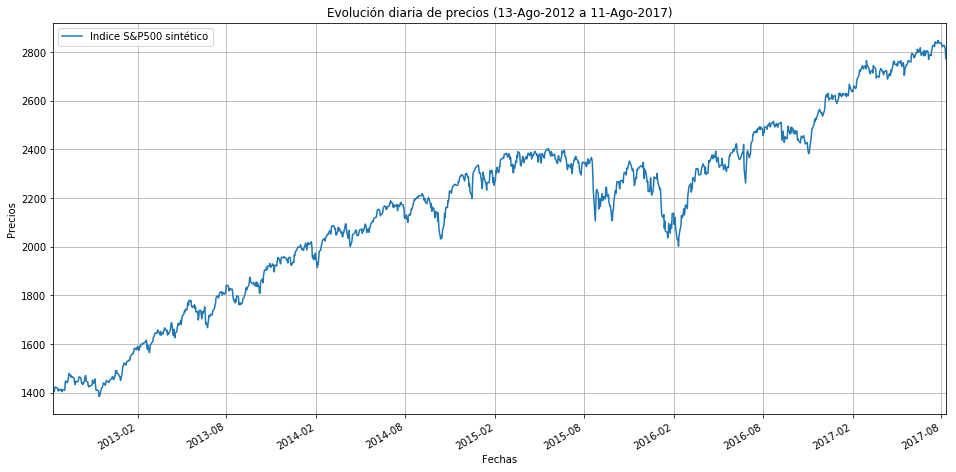

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,8))
indice['Close'].plot(grid = True)

plt.title ('Evolución diaria de precios (13-Ago-2012 a 11-Ago-2017)')
plt.ylabel('Precios')
plt.xlabel('Fechas')
plt.legend(['Indice S&P500 sintético'], loc = 0)

En análisis técnico bursátil, una de las comparativas básicas en un gráfico es ver la información de una cotización junto con una media móvil mensual (22 sesiones bursátiles). A partir de los distintos cruces entre el índice y su media móvil se considera que un mercado es alcista o bajista. Vamos a realizar esta comparativa.

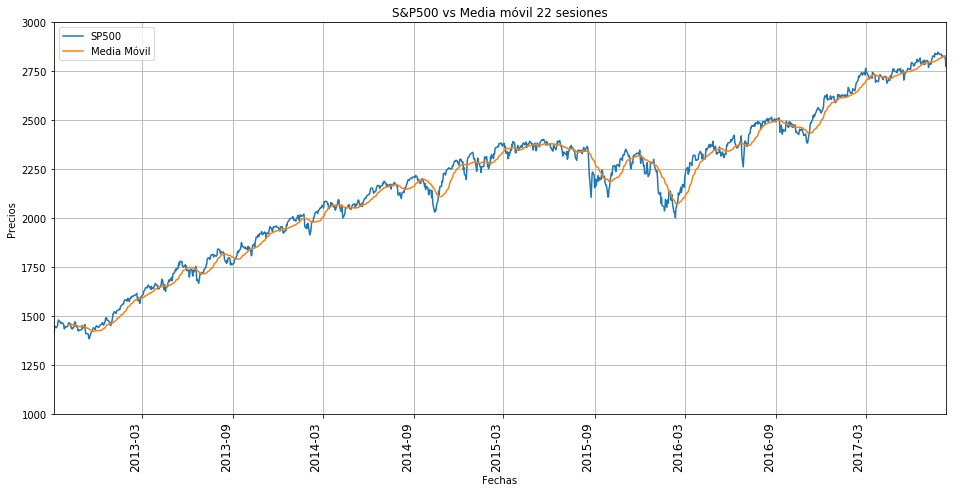

In [25]:
media_M = indice.loc['2012-09-04':,'Close']
media_M.plot(figsize=(16, 8), title='SP500',ylim=[1000,3000])
plt.legend(loc=0)
plt.xticks(size = 'large', rotation = 90)
plt.grid()

#media móvil
media_movilM = media_M.rolling(window=22).mean()[22:] #el primer rolling empieza el día 22 
media_movilM.plot(figsize=(16, 8), title='S&P500 vs Media móvil 22 sesiones',ylim=[1000,3000])
plt.legend(loc=0)
plt.xticks(size = 'large', rotation = 90)
plt.grid()

plt.ylabel('Precios')
plt.xlabel('Fechas')
plt.legend(['SP500','Media Móvil'], loc = 0)

Con la librería Bokeh vamos a utilizar velas japonesas (utilizadas en análisis técnico bursátil) para ver la evolución del periodo 2 de Enero 2013 a 28 de Marzo de 2013. Hemos elegido un periodo corto para visualizar mejor las velas.

In [26]:
# Dibujo de los candlesticks del índice para un periodo determinado (cuanto más pequeño mejor se ve).

from math import pi
from bokeh.plotting import figure, show, output_file
#inicio = input
candle = indice.loc['2013-01-02':'2013-03-28','Open':'Close']
candle.loc[:,'Date'] = candle.index
candle.loc[:,'Date'] = pd.to_datetime(candle.loc[:,'Date'])

inc = candle.loc[:,'Close'] > candle.loc[:,'Open']
dec = candle.loc[:,'Open'] > candle.loc[:,'Close']
w = 12*60*60*1000 

TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

p = figure(x_axis_type="datetime", tools=TOOLS, plot_width=1000, title = "Análisis técnico SP500 con velas japonesas")
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.3

p.segment(candle.loc[:,'Date'], candle.loc[:,'High'], candle.loc[:,'Date'], candle.loc[:,'Low'], color="black")
p.vbar(candle.loc[inc,'Date'], w, candle.loc[inc,'Open'], candle.loc[inc,'Close'], fill_color="#98fb98", line_color="black")
p.vbar(candle.loc[dec,'Date'], w, candle.loc[dec,'Open'], candle.loc[dec,'Close'], fill_color="#F2583E", line_color="black")

output_file("velas_japonesas.html")

show(p)

## CONSTRUCCION DE INDICES SECTORIALES

Las distintas compañías que integran el S&P 500 pertenecen a un sector concreto. Si agrupamos estas compañías por sectores y construimos un índice sectorial, podemos ver la distinta evolución que han tenido. Para llegar a esto tenemos que seguir varios pasos: 
* Descargar de Kaggle el listado de las compañías del S&P 500 y el sector al que pertenecen.
* Asignar a cada compañía su sector, para lo que añadiremos una nueva columna a nuestro data frame original _'Sector'_.
* Construir para cada sector un índice en base 100, con un periodo igual al de nuestro data frame original. Cada índice sectorial variará diariamente lo que fluctúe la media de las variaciones de las compañías que pertenecen a ese sector.

In [33]:
# Importación del data frame de Kaggle, y lo recogemos en una variable.
constituents_path = 'constituents-financials.csv'
# constituents_path = 'https://raw.githubusercontent.com/datasets/s-and-p-500-companies/master/data/constituents.csv'
constituents_read = pd.read_csv(constituents_path)

#----------- variable cn = constituents with only symbol and sector ----------- 
cn = pd.DataFrame(constituents_read.loc[:,['Symbol','Sector']])
sectors = np.unique(cn['Sector'])
print(sectors)

['Consumer Discretionary' 'Consumer Staples' 'Energy' 'Financials'
 'Health Care' 'Industrials' 'Information Technology' 'Materials'
 'Real Estate' 'Telecommunications Services' 'Utilities']


In [28]:
# Añadimos una nueva columna a nuestro dataframe original que recoja el sector al que pertenece cada compañía.
sp['Sector'] = sp['Name']
sp['Sector'] = sp['Sector'].map(cn.set_index('Symbol')['Sector'])
print(sp.head(5))
print(sp.tail(5))

        Date   Open   High    Low  Close     Volume Name       Sector
0 2012-08-13  92.29  92.59  91.74  92.40  2075391.0  MMM  Industrials
1 2012-08-14  92.36  92.50  92.01  92.30  1843476.0  MMM  Industrials
2 2012-08-15  92.00  92.74  91.94  92.54  1983395.0  MMM  Industrials
3 2012-08-16  92.75  93.87  92.21  93.74  3395145.0  MMM  Industrials
4 2012-08-17  93.93  94.30  93.59  94.24  3069513.0  MMM  Industrials
             Date   Open   High    Low  Close     Volume Name       Sector
606796 2017-08-07  62.12  62.34  61.25  61.83  4208287.0  ZTS  Health Care
606797 2017-08-08  60.49  61.00  59.50  60.00  4663668.0  ZTS  Health Care
606798 2017-08-09  59.95  60.87  59.76  60.81  4017297.0  ZTS  Health Care
606799 2017-08-10  60.87  61.37  59.71  59.74  2690725.0  ZTS  Health Care
606800 2017-08-11  60.05  60.22  59.64  59.73  2285863.0  ZTS  Health Care


In [29]:
sinsector = []
for i in np.where(sp.Sector.isnull()):
    sinsector.append(sp.iloc[i,-2])
print(np.unique(sinsector))

['ALGN' 'AMD' 'ANDV' 'ANSS' 'AOS' 'ARE' 'BHF' 'BHGE' 'DISH' 'DRE' 'DXC'
 'HLT' 'INFO' 'IT' 'MGM' 'NYSE:LMT' 'NYSE:NBL' 'NYSE:NWL' 'PKG' 'RE' 'RJF'
 'RMD' 'SNPS']


In [30]:
# Creamos un nuevo data frame que recogerá en base 100 la evolución diaria de cada sector. 
sectors = np.unique(cn['Sector'])
indicesector = pd.DataFrame(data = None, columns = sectors)

# Damos como index del data frame la fecha
indicesector['Date'] = pd.DataFrame(sp500)['Date']
indicesector = indicesector.set_index('Date')

# Asignamos el primer valor de la serie, que es 100.
indicesector.iloc[0][:] = 100
print(indicesector.head(5))

           Consumer Discretionary Consumer Staples Energy Financials  \
Date                                                                   
2012-08-13                    100              100    100        100   
2012-08-14                    NaN              NaN    NaN        NaN   
2012-08-15                    NaN              NaN    NaN        NaN   
2012-08-16                    NaN              NaN    NaN        NaN   
2012-08-17                    NaN              NaN    NaN        NaN   

           Health Care Industrials Information Technology Materials  \
Date                                                                  
2012-08-13         100         100                    100       100   
2012-08-14         NaN         NaN                    NaN       NaN   
2012-08-15         NaN         NaN                    NaN       NaN   
2012-08-16         NaN         NaN                    NaN       NaN   
2012-08-17         NaN         NaN                    NaN       NaN  

In [ ]:
indice_sectorial = sectorial.fillna(100) #rellenamos los NAN (en la primera fila) con la base 100
indice_sectorial = indice_sectorial * np.cumprod(sectorial) #calculamos la variación acumulada del índice para cada sector
print(indice_sectorial.head(3))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

#plt.figure(figsize=(40,8),legend=True)
#indice_sectorial.plot(grid = True)

#plt.title ('Índice por Sector')
#plt.ylabel('Precios')
#plt.xlabel('Fechas')

indice_sectorial.plot(figsize = (20, 8), title = 'Índice por Sector Base100',
                         ylim = [0, 350], 
                         marker = '^', markersize = 1, fontsize=12);

plt.legend(loc=0, fontsize=12)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Evolutivo Índice por Sector Base100', fontsize=12)
plt.grid()

In [ ]:
#PARA BORRAR HECHO EN EL ÍNDICE SECTORIAL
for sectores in sectors:
    indicesector.loc['2012-08-14':, sectores] = indicesector.loc['2012-08-13',sectores] * (
        np.cumprod(
            sectorial.loc[
                (sectorial.index.get_level_values('Sector') == sectores) & 
                (sectorial.index.get_level_values('Date') > '2012-08-13') &
                (sectorial.index.get_level_values('Date') <= '2017-08-11')

            ][:].values))
print(indicesector.head())

__VALORES CON MAYOR RENTABILIDAD__

Identificamos los valores con mayor rentabilidad calculando la variación media mensual acumulada por valor. Como rentabilidades pasadas no garantizan futuras, cogeremos sólo los datos del último año completo disponible, 2016. 

No obstante, el usuario puede modificar dos parámetros para adaptar el análisis a sus necesidades:

__1.__ Las fechas del __periodo de tiempo__ de análisis.En start and end. Note que los datos disponibles cubren el rango desde 2012 a Agosto de 2017.

__2.__ El __número (n) de Top valores__ con mayor variabilidad a analizar. 


__TOPN valores en RENTABILIDAD en 2016:__

In [ ]:
 #construimos índice en df en base a la fecha. Esto nos permite trabajar con columnas y filas más eficazmente.
sp['Date'] = pd.to_datetime(sp['Date'], format = '%d/%m/%Y')
sp.set_index(['Date'], inplace = True)
sp.head()

In [ ]:
#Preparamos los datos.
#Seleccionar mes y año para el rango de análisis

start = ('01-2016')
end = ('12-2016')
print('Periodo de análisis del ',start,'al ',end)
print('============================================')

rentabilidadM = sp.loc[start:end,['Name', 'Close']]   
rentabilidadM = rentabilidadM.groupby(['Name','Date']).sum()
rentabilidadM = rentabilidadM.unstack(level = 0)                         #preparamos estructura datos
rentabilidadM['EndMonth'] = rentabilidadM.index + pd.offsets.MonthEnd(1) #creamos los meses
rentabilidadM = rentabilidadM.groupby('EndMonth').mean()                 #agrupamos datos por mes

#Tenemos los datos y periodo de análisis. Identifiquemos los TopN.
#Introducir el N de valores con mayor rentabiliad que queramos visualizar

n=5 

nlargest_rentabilidad = pd.DataFrame(rentabilidadM.iloc[-1,:].nlargest(n)) #Indentifica los n largest
nlargest_rentabilidad = nlargest_rentabilidad.unstack(level=0).transpose() #Harmoniza forma para indexar 
nlargest_rentabilidad.columns[:]                              #Array de nombres de los n largest valores 
rentabilidadM = rentabilidadM.Close[nlargest_rentabilidad.columns[:]] #Salida datos nlargest

#Seleccionados los nlargest calculamos la rentabilidad en base 100 o variabilidad de cada valor en relación
#al valor de inicial, multiplicado por 100.

start_values=pd.DataFrame(rentabilidadM[:1],index=rentabilidadM.index)
print(start_values)
print('===================================================================')
print(rentabilidadM.head())
rentabilidadM = rentabilidadM.divide(start_values.iloc[0],axis=1)*100



print('Array de TopN valores en rentabilidad')
#print(nlargest_rentabilidad.columns[:])                             
print('======================================================================')
print('Head de datos para graficar el evolutivo de los Top',n,'valores en rentabilidad')
print(rentabilidadM.head())
print('======================================================================')
print("Estos son los sectores a los que pertenecen los 5 valores más rentables: ")
for sectorren in nlargest_rentabilidad.columns[:]:
    print("  El valor",sectorren, "pertenece al sector", sp[sp['Name'] == sectorren].iloc[5,-1],".")

__VALORES CON MAYOR VOLATILIDAD__

Identificar los N valores con mayor volatilidad nos da un primer paso para identificar el riesgo en una cartera de inversión.  __La volatilidad es lo que varía la rentabilidad de una acción respecto a su media, en un periodo determinado__ (estadísticamente es la desviación estándar de las variaciones diarias, agrupadas en un periodo).


Haremos el estudio de la volatilidad en base a la desviación estándar mensual. Volatilidades pasadas no garantizan volatilidades futuras, por lo tanto, cogeremos datos sólo del último año completo disponible, 2016. 

No obstante, el usuario puede modificar dos parámetros para adaptar el análisis a sus necesidades:

__1.__ Las fechas del __periodo de tiempo__ de análisis al igual que se hizo para la rentabilidad.

__2.__ El __número (n) de Top valores__ con mayor volatilidad a analizar. 


__TOPN valores en VOLATILIDAD en 2016:__

In [ ]:
start = ('01-2016')
end = ('12-2016')
print('Periodo de análisis del ',start,'al ',end)

volatilidadM = sp.loc[start:end,['Name', 'Close']]                     #Datos
volatilidadM = volatilidadM.groupby(['Name','Date']).sum()
volatilidadM = volatilidadM.unstack(level = 0).pct_change()            #preparamos estructura de datos
volatilidadM['EndMonth'] = volatilidadM.index + pd.offsets.MonthEnd(1) #creamos los meses
volatilidadM = volatilidadM.groupby('EndMonth').std()                  #agrupamos datos por mes

#Tenemos los datos y periodo de análisis. Identifiquemos los Top5
#Introducir el N de valores con mayor rentabiliad que queramos visualizar

n=5

nlargest_volatilidad = pd.DataFrame(volatilidadM.iloc[-1,:].nlargest(n)) #Indentifica los n largest
nlargest_volatilidad = nlargest_volatilidad.unstack(level=0).transpose() #Harmoniza forma para indexar 
nlargest_volatilidad.columns[:] #Array de nombres de los n largest valores 
volatilidadM = volatilidadM.Close[nlargest_volatilidad.columns[:]].head() #Salida datos nlargest

print('Array de TopN valores en volatilidad en Diciembre 2016')
print(nlargest_volatilidad.columns[:])                             
print('============================================================')
print('Datos para graficar el evolutivo de los Top',n,'valores en volatilidad')
print('Volatitilidades mensuales de los valores más volátiles en Diciembre de 2016')
print(volatilidadM.head())
print('============================================================')
print("Estos son los sectores a los que pertenecen los 5 valores más volátiles: ")
for sectorvol in nlargest_volatilidad.columns[:]:
    print("  El valor",sectorvol, "pertenece al sector", sp[sp['Name'] == sectorvol].iloc[5,-1],".")

In [ ]:
### GRÁFICO RENTABILIDAD

import matplotlib.pyplot as plt
% matplotlib inline

print('Datos evolutivo de los Top',n,' valores más rentables')
print(rentabilidadM.head())

rangomin = round(rentabilidadM.min().min()) #min. valor matriz datos para rango eje Y
rangomax = round(rentabilidadM.max().max()) #max. valor matriz datos para rango eje Y

chart = rentabilidadM.plot(figsize = (15, 4), title = 'Top valores más rentables: %s - %s' % (start,end),
                         ylim = [rangomin-20, rangomax+20], 
                         marker = '^', markersize = 4);

plt.legend(loc=0)
plt.xlabel('Mes')
plt.ylabel('Rentabilidad Base 100')
plt.grid()

# GRÁFICO VOLATILIDAD

print('==================================')
print('Datos evolutivo de los Top',n,' valores más volátiles')
print(volatilidadM.head())

rangomax_var = round(volatilidadM.max().max()) #max. valor matriz datos para rango eje Y

chart=volatilidadM.plot(figsize = (15, 4), 
                         title = 'Volatilidades mensuales de los valores con mayor volatilidad en Diciembre de 2016', 
                         ylim = [0, rangomax_var+0.1], 
                         marker = '^', markersize = 4);
plt.legend(loc=0)
plt.xlabel('Mes')
plt.ylabel('Volatilidad')
plt.grid()

Vamos a ver si hay alguna __correlación entre los valores que presentan mayor volatilidad__. Si la hay, nos darían valores sobre los que poder una estrategia de inversión conjunta. 

In [ ]:
import seaborn as sns

start = ('01-2016')
end = ('12-2016')
    
      
#Gráfico matriz correlaciones
fig = plt.figure(figsize=(6,6))
r = sns.heatmap(volatilidadM.corr(), cmap='BuPu', annot=True)
r.set_title("Densidad de correlaciones")
print('=== MATRIZ CORRELACIONES VALORES MAYOR VARIABILIDAD ===')
print('Periodo de análisis del ',start,'al ',end)
print(volatilidadM.corr())
print('===================GRAFICO VALORES=====================')

Se observa que los hay una alta correlación entre los pares de valores MU y HLT (89%), y también entre NFX y MRO (84%), lo que indica que ambos valores suelen variar en la misma media. 

__ESTUDIO DEL VALOR CON MAYOR VOLATILIDAD__

Vamos a profundizar en el estudio del valor con mayor volatilidad. Evaluaremos si presenta estacionalidad y veremos su componentes de tendencia y cíclicos durante el periodo elegido. El objetivo es obtener información para definir la estrategia de inversión en el mismo.

Utilizaremos el análisis de componentes que desagrega el evolutivo de una acción en cuatro partes:
- __Nivel:__ Valores de la serie temporal.
- __Tendencia:__ Tendencia creciente o decreciente en la serie de datos.
- __Estacionalidad:__ Repeticiones del comportamiento a c/p (corto plazo) durante el periodo.
- __Ruido:__ Variación random a lo largo del periodo analizado.

En el valor seleccionado vemos que tiene una clara estacionalidad mensual. Subiendo practicamente la primera mitad del mes y bajando durante la segunda mitad del mismo. La tendencia del valor es al alza. 

Primero indentificaremos el valor con mayor volatilidad.

In [ ]:
#OPCIONAL SI SE PUEDE TERMINAR. FALTA AÑADIRLE QUE COGE AUTOMÁTICAMENTE EL VALOR MÁS VOLÁTIL
#Selecciona el periodo mensual deseado para el análisis 
start = ('01-2016')
end = ('12-2016')

from pandas.core import datetools
volatilidad_mean=volatilidadM.agg(['mean'])
max_volatilidad= volatilidad_mean[[max(volatilidad_mean)]]
print(volatilidad_mean)
print(max_volatilidad)
name=max(volatilidad_mean) #nombre del valor más volatil
#print(max(volatilidad_mean.max())) #valor medio del valor más volatil

componentes_data=sp.loc[start:end,['Name','Close']].groupby(['Name','Date']).sum().unstack(level=0)
#componentes_data_MMM=componentes_data[(componentes_data.columns[3])]
#componentes_data_MMM=componentes_data[(componentes_data.columns.levels=='PCLN')]
cierres = sp[sp['Name'] == name]['Close']
print(cierres)

print(componentes_data.head(2))
print(componentes_data.columns.get_level_values('Close'))


import statsmodels as sm
import statsmodels.api as sm

descomposicion=sm.tsa.seasonal_decompose(componentes_data_MMM, model='additive',freq=22)  
descomposicion.plot()
plt.minorticks_on()
plt.xticks(size = 'medium', rotation = 90) 
plt.axhline(0, color = 'r')

## CONTRASTE DE HIPÓTESIS
El S&P500 originariamente estaba compuesto por cada una de las 500 compañías de mayor capitalización de los mercados norteamericanos de renta variable. Hoy por hoy el número ha crecido hasta los 505 (aunque este dataframe tiene 503 valores distintos) debido a que hay varias compañías con dos clases de acciones cotizando.
Estas compañías son:
* Google (con acciones cotizando con name GOOG y GOOGL), 
* Under Armour (UA, UAA), 
* Discovery Communications (DISCA, DISCK), 
* News Corp (NWSA, NWS), 
* Twenty-One Century Fox (FOXA, FOX). 

Queremos hacer un contraste de hipótesis, y demostrar mediante estadística que en Google, las dos clases de acciones se comportan exactamente igual.

#ANOTACIONES DE LOURDES:
Fernando, si haces un ANOVA para el contraste, explicaria un poco el modelo. Lo de abajo es una definición de internet. La diapositiva 11 de este ppt muestra los contrastes según tipo de variables y otros criterios.
https://es.slideshare.net/rruizdeadana/unidad-8-eleccion-de-la-prueba-de-significacion-estadistica

Creo que tu caso se podría hacer con una two-sample t-student porque tus dos series de datos son de diferentes poblaciones. En mi caso por ejemplo es sobre una misma población de datos. El ANOVA require esto en los datos. En el caso de las acciones, lo que pongo en negrita abajo, no se cumple.

Condiciones:

En ANOVA de un factor solo se relacionan dos variables: una variable dependiente (o a explicar) y una variable independiente (que en esta técnica se suele llamar factor)
__La variable dependiente es cuantitativa (escalar) y la variable independiente es categórica (nominal u ordinal).__
Se pide que las variables sigan la distribución normal, aunque como siempre esto es difícil de cumplir en investigaciones sociales. 
También que las varianzas (es decir, las desviaciones típicas al cuadrado) de cada grupo de la variable independiente sean similiares (fenómeno que se conoce como homocedasticidad). Aunque esto es lo ideal, en la realidad cuesta de cumplir, e igualmente se puede aplicar ANOVA

http://hamelg.blogspot.com.es/2015/11/python-for-data-analysis-part-24.html


In [ ]:
# CREAMOS DATA FRAME PARA RECOGER LOS VALORES DE LA COLUMNA 'CLOSE' DE GOOG Y GOOGL, PERO SOLO A PARTIR DEL 3 ABR 2014,
# QUE ES CUANDO SE PRODUCE EL DESDOBLAMIENTO DE LA ÚNICA ACCIÓN QUE HABÍA HASTA ENTONCES.

google = pd.DataFrame(data = sp[sp['Name'] == 'GOOG'].loc[:,['Close']])
google.columns = ['GOOG']
google['GOOGL'] = sp[sp['Name'] == 'GOOGL']['Close'].values
google = google.loc['2014-04-03':,]
print(google.tail(5))

In [ ]:
# Dibujamos la evolución de los cierres diarios de los dos valores.

import matplotlib.pyplot as plt

pylab.rcParams['figure.figsize'] = (15, 9)

google['GOOG'].plot(grid = True)
google['GOOGL'].plot(grid = True)

plt.title ('Evolución diaria de precios GOOG y GOOGL')
plt.ylabel('Precios')
plt.legend(['GOOG','GOOGL'], loc = 0)

A la vista del gráfico, parece que las dos series de precios tienen un comportamiento similar. 

Vamos a realizar un análisis sobre esto, valorar la posibilidad de que se comporten igual. 

Para ello, un primer acercamiento podría ser ver el coeficiente de correlación entre ambas series:

In [ ]:
google['GOOG'].corr(google['GOOGL'])

Vemos que la correlación es del 99,88%, por tanto sí que parece que tengan dependencia una de la otra. 

Vamos a profundizar un poco más en el análisis y comprobarlo realizando un contraste de hipótesis.

Pero antes, para hacer comparativas de series de datos deberíamos normalizar las series, puesto que las series de precios a pesar de ser similares son diferentes. Para conseguir esto hay varias técnicas, y elegiremos la más adecuada en función del resultado que arroje cada una:
* Normalizar las variables o estandarizarlas (a la vista de los plot parece mejor estandarizar)
* Trabajar con las variaciones en % de los valores
* Trabajar en base 100

Preparamos las series de datos que vamos a necesitar para nuestro análisis:

### a) Normalizar las variables

In [ ]:
# Normalizamos los datos de los dos valores, GOOG y GOOGL, con la librería de Python sklearn
from sklearn import preprocessing
normalized_google = preprocessing.normalize(google)

# Reconvertimos los arrays en dataframe, para usar librería PLOT
normalized_google = pd.DataFrame(data=normalized_google[0:,0:], index=google.index, columns= ['GOOG', 'GOOGL'])

# Dibujamos los dos valores, ya normalizados
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

normalized_google.plot(grid = True)

plt.title ('Evolución diaria de precios GOOG y GOOGL')
plt.ylabel('Precios')
plt.legend(['GOOG','GOOGL'], loc = 0)

Aunque vemos similitud en el comportamiento no parece que la técnica nos de la serie de serie de datos con la que queremos trabajar.

Vamos por tanto a ver otra forma de transformar la serie de datos.
### b) Estandarizar las variables

In [ ]:
# Estandarizamos los datos de los dos valores, GOOG y GOOGL, con la librería de Python sklearn
from sklearn import preprocessing
standardized_google = preprocessing.scale(google)
# Reconvertimos los arrays en dataframe, para usar librería PLOT
standardized_google = pd.DataFrame(data=standardized_google[0:,0:], index=google.index, columns= ['GOOG', 'GOOGL'])


# Dibujamos los dos valores, ya standarizados
import matplotlib.pyplot as plt   # Import matplotlib
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

standardized_google.plot(grid = True)

plt.title ('Evolución diaria de precios GOOG y GOOGL')
plt.ylabel('Precios')
plt.legend(['GOOG','GOOGL'], loc = 0)

Este gráfico muestra que los datos que tenemos ahora son una mejor aproximación a lo que buscamos, que tengan la misma escala de precios.

No obstante, vamos a comprobar otras dos formas de transformar los datos.

### c) Trabajar con variaciones diarias en % de las series

In [ ]:
# Añadimos a nuestro dataframe 'google' un nuevo par de columnas:
# 1) Las variaciones porcentuales diarias de los precios.
google['GOOGChange'] = google['GOOG'].pct_change()+1
google['GOOGLChange'] = google['GOOGL'].pct_change()+1
print(google.head(5))

In [ ]:
# Dibujamos los dos valores, trabajando con las variaciones 
import matplotlib.pyplot as plt   # Import matplotlib
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

GOOGCHG = google['GOOGChange']
GOOGLCHG = google['GOOGLChange']

GOOGCHG.plot(grid = True)
GOOGLCHG.plot(grid = True)

plt.title ('Variación diaria en % de los precios de GOOG y GOOGL')
plt.ylabel('Precios')
plt.legend(['GOOG','GOOGL'], loc = 0)

Parecen datos bastante homogéneos entre sí, válidos también para trabajar con ellos.

### d) Trabajar en base 100

In [ ]:
# Construimos las series de precios diarias en base 100, a partir de las variaciones diaris en %.
google['goog'] = 100
google['googl'] = 100
google.loc[1:,'goog'] = google.goog.iloc[0] * np.cumprod(google.GOOGChange.iloc[1:])
google.loc[1:,'googl'] = google.googl.iloc[0] * np.cumprod(google.GOOGLChange.iloc[1:])

print(google.head(5))

In [ ]:
# Dibujamos las dos series de valores, en base 100
import matplotlib.pyplot as plt   # Import matplotlib
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

google['goog'].plot(grid = True)
google['googl'].plot(grid = True)

plt.title ('Evolución diaria de precios GOOG y GOOGL')
plt.ylabel('Precios')
plt.legend(['GOOG','GOOGL'], loc = 0)

### ESTA ES LA PARTE QUE QUITARÍA, DEL ANOVA DE 1 FACTOR Y DEJAR SOLO LA T-STUDENT
Estos datos no parecen muy válidos para trabajar con ellos, puesto que si existen diferencias entre las muestras de ambas series, al ir acumulando diariamente estas se van haciendo cada vez más grandes, no son datos independientes, sino que cada uno tiene en cuenta el pasado.

__Entre las dos formas de normalizar los datos preferimos la de trabajar con las variaciones % diarias.__

<code>f_oneway</code> tests the null hypothesis that two or more groups have the same population mean. The hypothesis is rejected if any of these probabilities is less than or equal to a small, fixed but arbitrarily pre-defined threshold value $\alpha$, which is referred to as the level of significance.

However, it has some assumptions: http://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.stats.f_oneway.html   Do they hold in our case? 

In [ ]:
print('Correlación: ', GOOGCHG.corr(GOOGLCHG), 'Covarianza: ',GOOGCHG.cov(GOOGLCHG))
print('Medias', GOOGCHG.mean(), GOOGLCHG.mean())

# compute one-way ANOVA P value 
# from 3 samples (for two equiv. t-test)
from scipy import stats  

f_val, p_val = stats.f_oneway(GOOGCHG, GOOGLCHG)        
print ("One-way ANOVA P =", p_val )

from scipy.stats import ttest_1samp
t, p = ttest_1samp(GOOGCHG, 0)
# If p is large, we can accept that the population has the mean indicated.
print(p)
t2, p2 = ttest_1samp(GOOGLCHG, 0)
print(p2)

### ESTA PARTE DEL TTEST ES LA QUE SE DEJA Y LAS CELDAS DE CÓDIGO ANTERIORES QUE SEAN NECESARIAS. CREO QUE TODAS MENOS LAS DE ANOVA. PERO ECHA OTRO VISTAZO POR SI HAY QUE ELIMINAR ALGUNA MÁS.

PERO TE SALE QUE SE RECHAZARÍA LA Ho Y LAS MEDIAS SERIAN IGUALES. REVISA COMO HE NORMALIZADO LOS DATOS CON UNA FUNCIÓN EN LA MÍA Y lanza el turyo OTRA VEZ con esas modificaciones. LUEGO INTERPRETAS EL P SEGÚN EL MÍO Y LISTO. 

Ayuda de la función ttest_ind:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

In [ ]:
#CON ESTE ES SUFICIENTE. 

min_max_scaler = preprocessing.MinMaxScaler() #df_norm = (df - df.mean()) / (df.max() - df.min())
np_scaled = min_max_scaler.fit_transform(GOOG, GOOGL)
df_normalized = pd.DataFrame(np_scaled, columns =['GOOGnorm', 'GOOGLnorm'])

print('======== DATOS NORMALIZADOS ========')
print(df_normalized)

#T-TEST para 2 poblaciones con datos relacionados. En este caso el índice deflactado se construye 
#a partir de los de Indice en Close.

GOOGnorm=df_normalized.IndiceSP
GOOGLnorm=df_normalized.Indice_deflactado


import scipy.stats as stats
sample1 = np.random.randn(10, 1)
sample2 = 1 + np.random.randn(15, 1)
t_stat, p_val = stats.ttest_ind(GOOGnorm, GOOGLnorm, equal_var=False)
print(t_stat)
#array([-3.94339083])
print(p_val)
#array([ 0.00070813])


__INTERPRETACIÓN DE RESULTADOS:__

En teoría:

1. p-value > 0.05 o 0.1. Ho no se puede rechazar. Las medias son diferentes.

2. p-value < 0.05 o 0.1, ej: 1%, 5% o 10%, entonces rechazamos Ho, aceptando H1. Las medias son iguales. 

Esto es así porque valores pequeños de p están asociados a valores altos en t-student. Hay una correlación inversa entre ambos.

El __p-value obtenido es de 0.00984 < 0.05 (α = 5%)__.  Por lo tanto rechazamos Ho.

Podemos afirmar que a largo plazo el Indice S&P genera ganancias reales, por encima de la inflación. 

### ¿SE GANA EN LA BOLSA A LARGO PLAZO?

Muchos pequeños inversionistas y no inversionistas se plantean la pregunta de si realmente la bolsa genera ganancias a l/p. Los expertos en economía afirman que sí, pero claro, disponiendo de un mínimo de conocimientos para elegir los valores y el momento en el tiempo más adecuado para invertir.

Vamos a intentar responder a esta pregunta con una aproximación sencilla dada la limitación de los datos disponibles.


Fuente para sacar los datos de inflación en US: http://www.inflation.eu/inflation-rates/united-states/historic-inflation/cpi-inflation-united-states.aspx

__Datos__: Compararemos el evolutivo del Índice S&P y el mismo Índice ajustado a la inflación (_Índice deflactado_). 

__Perido__: Cogeremos los datos del histórico del que disponemos, incluyendo 2017 que no está completo, en base anual acorde a los datos de inflación disponibles en el link de más arriba.

In [ ]:
from pylab import figure, show

datos_Ho = pd.DataFrame(indice.groupby(indice.index.year).last()['Close'])
inflacion_rate=pd.Series([0.0174,0.0150,0.0076,0.0073,0.0207,0.0211], 
                         index= datos_Ho.index, name='Inflation', 
                         dtype='float32')
datos_Ho = pd.concat((datos_Ho,inflacion_rate), axis=1, join='inner', names=['Indice', 'Inflacion'])
datos_Ho['Indice_deflactado'] = datos_Ho.Close * (1-datos_Ho.Inflation)

print(datos_Ho)
print(datos_Ho.mean())


datos_Ho[['Close','Indice_deflactado']].plot(figsize=(16,4), 
                                                           color=('navy','lightseagreen'))
plt.grid()
plt.title('Comparativa Indice S&P e Indice_deflactado anual')
plt.legend(fontsize=12, labels=('Indice', 'Indice_deflactado'))
#plt.fill_between('Indice_variabiliad',0,'Indice_deflactado_variabilidad')

Como vemos en la gráfica el índice ajustado a la inflación o deflactado ha estado siempre por encima del Indice a precios normales. Esto indica que en el periodo de análisis 2012-2017 la bolsa ha tenido un rendimiento superior a la inflación, incluso entre 2013 y 2015 donde ambos índices tuvieron valores más cercanos.

Podemos intuir que con un mínimo de conocimientos, invertir en el S&P parece rentable a largo plazo. 

Vamos a plantear un __contraste de hipótesis.__ Si las medias son estadísticamente diferentes, podemos asumir que los valores superiores del Indice sobre el deflactado no se dan por casualidad.  

1. __Ho.__ Las medias de los índices son diferentes.
2. __H1.__ Las medias de los índices son iguales.


- si __p ≤ α, aceptar H1__

- si __p > α, aceptar H0__

__α = 5%__


In [ ]:
from scipy import stats
from sklearn import preprocessing

print('======== MEDIAS DE LAS SERIES ========')
print(round(datos_Ho.Close.mean(),3))
print(round(datos_Ho.Indice_deflactado.mean(),3))

min_max_scaler = preprocessing.MinMaxScaler() #df_norm = (df - df.mean()) / (df.max() - df.min())
np_scaled = min_max_scaler.fit_transform(datos_Ho[['Close','Indice_deflactado']])
df_normalized = pd.DataFrame(np_scaled, columns =['IndiceSP', 'Indice_deflactado'])
print('======== DATOS NORMALIZADOS ========')
print(df_normalized)

#T-TEST para 2 poblaciones con datos relacionados. En este caso el índice deflactado se construye 
#a partir de los de Indice en Close.

Indice=df_normalized.IndiceSP
Indice_deflactado=df_normalized.Indice_deflactado

print('=========== T-TEST para datos poblaciones relacionados =========')
print(stats.ttest_rel(df_normalized.IndiceSP,
                df_normalized.Indice_deflactado))

dfcalc = len(df_normalized.IndiceSP) + len(df_normalized.Indice_deflactado) - 2 #grados de libertad
print('Grados de libertad del test %s: ',dfcalc) 

__INTERPRETACIÓN DE RESULTADOS:__

En teoría:

1. p-value > 0.05 o 0.1. Ho no se puede rechazar. Las medias son diferentes.
2. p-value < 0.05 o 0.1, ej: 1%, 5% o 10%, entonces rechazamos Ho, aceptando H1. Las medias son iguales. 

Esto es así porque valores pequeños de p están asociados a valores altos en t-student. Hay una correlación inversa entre ambos.

El __p-value obtenido es de 0.11 > 0.05 (α = 5%)__.  Por lo tanto aceptamos Ho.

Podemos afirmar que a largo plazo el Indice S&P genera ganancias reales, por encima de la inflación. 